## Hospedagens em Recife
Buscamos analisar as mudanças sazonais do preço das hospedagens em recife

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from fancyimpute import KNN
from scipy.stats import f_oneway, kruskal, shapiro
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [69]:
# carregando o dataset completo
hosp = pd.read_csv('../resultado1.csv', decimal=".")

## Definindo o tipo dos dados

In [70]:
hosp['checkin'] = pd.to_datetime(hosp['checkin'])
hosp['checkout'] = pd.to_datetime(hosp['checkout'])
hosp['cidade'] = hosp["cidade"].astype("category")
hosp['hotel'] = hosp["hotel"].astype("category")
hosp['data_extracao'] = hosp["data_extracao"].astype("category")

In [71]:
# pegando do dataset apenas os dados até junho de 2025 para comparar um ano inteiro sem repetições
hospedagens = hosp[~((hosp['checkin'].dt.month > 6) & (hosp['checkin'].dt.year == 2025))]

In [72]:
# confirmando o tipo dos dados
hospedagens.dtypes

hotel                    category
cidade                   category
preço                       int64
checkin            datetime64[ns]
checkout           datetime64[ns]
dist_centro               float64
dist_praia                float64
avaliacao                 float64
qtnd_avaliacoes           float64
data_extracao            category
dtype: object

## Estatísticas Iniciais

In [73]:
# tamanho dos dados
hospedagens.shape

(15643, 10)

In [74]:
# visualizando as colunas 
hospedagens.columns

Index(['hotel', 'cidade', 'preço', 'checkin', 'checkout', 'dist_centro',
       'dist_praia', 'avaliacao', 'qtnd_avaliacoes', 'data_extracao'],
      dtype='object')

In [75]:
# uma breve descrição dos dados
hospedagens.describe()

,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes
count,15643.000000,15643,15643,15643.000000,11037.000000,12510.000000,12510.000000
mean,2091.195551,2024-11-15 05:30:06.328709120,2024-11-22 05:30:06.328709376,8.357665,0.580475,8.190392,448.566427
min,226.000000,2024-07-01 00:00:00,2024-07-08 00:00:00,0.200000,0.000000,1.000000,1.000000
25%,1188.000000,2024-08-22 00:00:00,2024-08-29 00:00:00,4.300000,0.100000,7.700000,3.000000
50%,1638.000000,2024-11-01 00:00:00,2024-11-08 00:00:00,6.800000,0.450000,8.600000,14.000000
75%,2270.000000,2025-01-22 00:00:00,2025-01-29 00:00:00,9.500000,0.750000,9.500000,96.000000
max,20793.000000,2025-06-22 00:00:00,2025-06-29 00:00:00,89.400000,3.000000,10.000000,8861.000000
std,1874.089123,NaN,NaN,7.928466,0.703904,1.935681,1156.761127


O desvio padrão gigantesto do preço chama a atenção juntamente com o máximo valor, indicando possíveis outliers.

In [76]:
# agrupamos os dados por mês para entender a média dos preços de cada mês
preco_medio_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()
preco_medio_mensal

checkin
2024-07-31    1853.438967
2024-08-31    1852.081880
2024-09-30    1936.745310
2024-10-31    1977.388763
2024-11-30    2011.614892
2024-12-31    2269.954579
2025-01-31    2461.325480
2025-02-28    2248.170360
2025-03-31    2720.275000
2025-04-30    2325.341146
2025-05-31    2297.971154
2025-06-30    2122.087601
Freq: M, Name: preço, dtype: float64

In [77]:
# agrupamos os dados por mês para entender a mediana dos preços de cada mês
preco_mediano_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()
preco_mediano_mensal

checkin
2024-07-31    1567.0
2024-08-31    1487.0
2024-09-30    1595.0
2024-10-31    1620.0
2024-11-30    1638.0
2024-12-31    1712.0
2025-01-31    2004.0
2025-02-28    1707.5
2025-03-31    1895.0
2025-04-30    1762.0
2025-05-31    1714.0
2025-06-30    1575.0
Freq: M, Name: preço, dtype: float64

Com a média e mediana dos dados, podemos ver que em alguns meses os valores são mais altos ou baixo, destacando uma provável variabilidade dos preços.

In [78]:
# número de acomodações aparecendo por mês
num_hospedagens_mes = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].count()
num_hospedagens_mes

checkin
2024-07-31    2130
2024-08-31    2064
2024-09-30    1759
2024-10-31    1762
2024-11-30    1719
2024-12-31    1343
2025-01-31    1146
2025-02-28     722
2025-03-31     760
2025-04-30     768
2025-05-31     728
2025-06-30     742
Freq: M, Name: preço, dtype: int64

Aqui podemos perceber, que ao longo do tempo, o número de acomodações disponíveis para reserva vai caindo. O padrão demonstra que provavelmente uma boa parte dos hóteis, não fazem um cadastro para reserva tão antecipadamente. Com isso, cada mês se torna um grupo de análise diferente.

In [79]:
# criando uma coluna para armazenar o mês do checkin
# é interessante pois vamos analisar a sazonalidade dos dados
hospedagens['mes_checkin'] = hospedagens['checkin'].dt.month

C:\Users\Clara\AppData\Local\Temp\ipykernel_37468\2195187864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['mes_checkin'] = hospedagens['checkin'].dt.month


Em seguida vamos pegar apenas as hospedagens que aparecem em todos os check-ins do dataset. O objetivo é avaliar se os hóteis que aparacem em todas as datas possuem um viés claro (como preços mais elevados).

In [80]:
# Contar a quantidade de semanas distintas para cada hotel
hotel_week_count = hospedagens.groupby('hotel')['checkin'].nunique()

# Identificar o número máximo de semanas no período (52 semanas em um ano)
max_weeks = hospedagens['checkin'].nunique()

# Identificar os hotéis que aparecem em todas as semanas
hotels_all_weeks = hotel_week_count[hotel_week_count == max_weeks].index

# Filtrar o DataFrame para manter apenas os hotéis que aparecem em todas as semanas
hospedagens_filtered = hospedagens[hospedagens['hotel'].isin(hotels_all_weeks)]
hospedagens_filtered

C:\Users\Clara\AppData\Local\Temp\ipykernel_37468\413734298.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hotel_week_count = hospedagens.groupby('hotel')['checkin'].nunique()


,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
23,Flat em Boa Viagem,Recife,1190,2024-07-01,2024-07-08,9.4,0.1,7.4,1798.0,2024-6-6,7
24,Casa Recife Pousada,Recife,421,2024-07-01,2024-07-08,8.2,1.1,7.1,602.0,2024-6-6,7
27,Hotel Dan Inn Mar Piedade - Grande Recife,Recife,1953,2024-07-01,2024-07-08,13.7,0.0,7.8,2778.0,2024-6-6,7
33,Marante Plaza Hotel,Recife,3079,2024-07-01,2024-07-08,5.0,0.0,8.3,2420.0,2024-6-6,7
39,Flat em Boa Viagem,Recife,1070,2024-07-01,2024-07-08,9.3,0.1,7.4,461.0,2024-6-6,7
...,...,...,...,...,...,...,...,...,...,...,...
15634,flatpaivahome bugan paiva,Recife,1886,2025-06-22,2025-06-29,19.6,0.7,NaN,NaN,2024-6-6,6
15636,Apto a beira-mar em Jaboatao dos Guararapes PE,Recife,2050,2025-06-22,2025-06-29,19.4,0.6,9.0,2.0,2024-6-6,6
15637,Apt novíssimo Tamarineira,Recife,3780,2025-06-22,2025-06-29,4.1,NaN,10.0,4.0,2024-6-6,6
15638,Hostel da Socorro,Recife,2835,2025-06-22,2025-06-29,9.0,0.9,1.0,1.0,2024-6-6,6


In [81]:
# mediana dos preços das hospedagens que possuem o ambiente disponível em todos os checkins
hospedagens_filtered['preço'].median()

1714.0

In [82]:
# mediana dos preços do dataset completo
hospedagens['preço'].median()

1638.0

Podemos ver acima a mediana dos dados completos e a mediana dos dados que aparecem em todos os checkins. A diferença das medianas não parece ser tão significativa, então, preferimos por não optar pela imputação desses dados, já que essa iniciativa poderia modificar o principal fator de análise em questão.

In [83]:
hospedagens_filtered['preço'].std()

2982.846868705144

In [84]:
hospedagens['preço'].std()

1874.0891232783397

Diferença considerável no desvio padrão, provavelmente ocasionada pela menor consistência dos dados e bastante outliers.

In [85]:
# calculando o desvio padrão dos preços médios dos meses
preco_medio_mensal['price_change'] = preco_medio_mensal.std()
preco_medio_mensal['price_change']


263.601427112874

Apresenta um desvio padrão alto, indicando uma boa variação de valores no preço.

<Axes: >

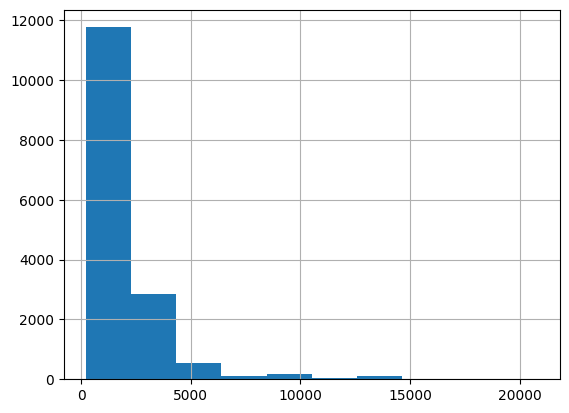

In [86]:
# hiistograma do preço de estadia por 7 dias
hospedagens['preço'].hist()

A coluna de preços apresenta uma assimetria considerável, com valores que chegam a quase 20000.

## Definindo dados faltantes

In [87]:
# printando quantas linhas de cada coluna está faltante
print(hospedagens.isnull().sum())

hotel                 0
cidade                0
preço                 0
checkin               0
checkout              0
dist_centro           0
dist_praia         4606
avaliacao          3133
qtnd_avaliacoes    3133
data_extracao         0
mes_checkin           0
dtype: int64


3 colunas com uma quantidade até considerável de dados faltantes

<Axes: >

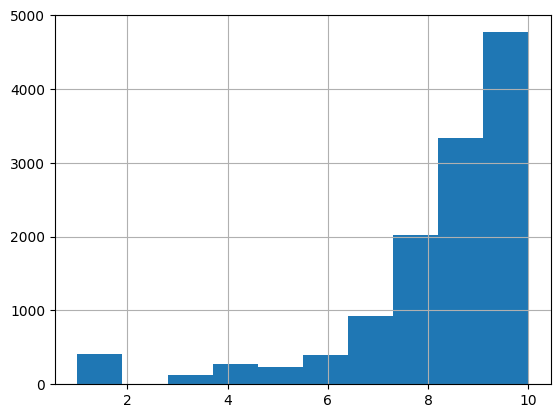

In [88]:
# vamos plotar histogramas das colunas com dados faltantes para entender as particularidades
hospedagens["avaliacao"].hist()

<Axes: >

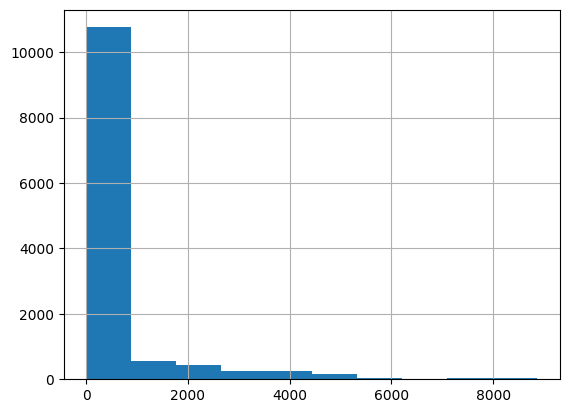

In [89]:
hospedagens["qtnd_avaliacoes"].hist()

<Axes: >

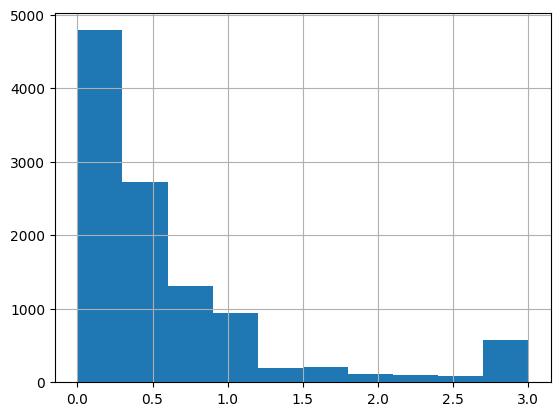

In [90]:
hospedagens["dist_praia"].hist()

Todas as colunas analisadas são assimétricas e apresentam uma quantidade considerável de dados faltantes.

In [91]:
# gerando um novo dataset a partir do csv com os dados e transformando os dados categóricos em numérico
hosp_input = pd.read_csv('../resultado1.csv', decimal=".")
hosp_input['checkin'] = pd.to_datetime(hosp_input['checkin'])
hosp_input['mes_checkin'] = hosp_input['checkin'].dt.month
hosp_input = hosp_input[~((hosp_input['checkin'].dt.month > 6) & (hosp_input['checkin'].dt.year == 2025))]
hosp_input['checkin'] = hosp_input['checkin'].astype("category")
hosp_input['checkout'] = hosp_input['checkout'].astype("category")
hosp_input['cidade'] = hosp_input["cidade"].astype("category")
hosp_input['hotel'] = hosp_input["hotel"].astype("category")
hosp_input['data_extracao'] =hosp_input["data_extracao"].astype("category")
hosp_input['hotel'] = hosp_input['hotel'].cat.codes
hosp_input['checkin'] = hosp_input['checkin'].cat.codes
hosp_input['checkout'] = hosp_input['checkout'].cat.codes
hosp_input['cidade'] = hosp_input['cidade'].cat.codes
hosp_input['data_extracao'] = hosp_input['data_extracao'].cat.codes
hosp_input.shape

(15643, 11)

Vamos ver a correlação dos dados para entender mais sobre a relação entre eles. Vamos usar spearman por termos dados não simétricos.

In [92]:
# entendendo a correlação dos dados a partir do método spearman (dados não simétricos)
hosp_input.corr(method="spearman")

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
hotel,1.000000,NaN,-0.045768,-0.013961,-0.013941,-0.052071,0.079522,-0.137409,0.130129,NaN,0.012697
cidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preço,-0.045768,NaN,1.000000,0.092607,0.092925,0.114370,-0.177471,0.127552,0.047562,NaN,-0.049790
checkin,-0.013961,NaN,0.092607,1.000000,0.988251,-0.014037,0.022954,0.018551,-0.071389,NaN,-0.298065
checkout,-0.013941,NaN,0.092925,0.988251,1.000000,-0.013602,0.022948,0.017814,-0.070567,NaN,-0.298065
dist_centro,-0.052071,NaN,0.114370,-0.014037,-0.013602,1.000000,-0.206097,-0.048546,0.147993,NaN,0.009141
dist_praia,0.079522,NaN,-0.177471,0.022954,0.022948,-0.206097,1.000000,-0.055413,-0.221707,NaN,-0.019462
avaliacao,-0.137409,NaN,0.127552,0.018551,0.017814,-0.048546,-0.055413,1.000000,-0.209505,NaN,-0.007647
qtnd_avaliacoes,0.130129,NaN,0.047562,-0.071389,-0.070567,0.147993,-0.221707,-0.209505,1.000000,NaN,0.047857
data_extracao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='dist_praia', ylabel='preço'>

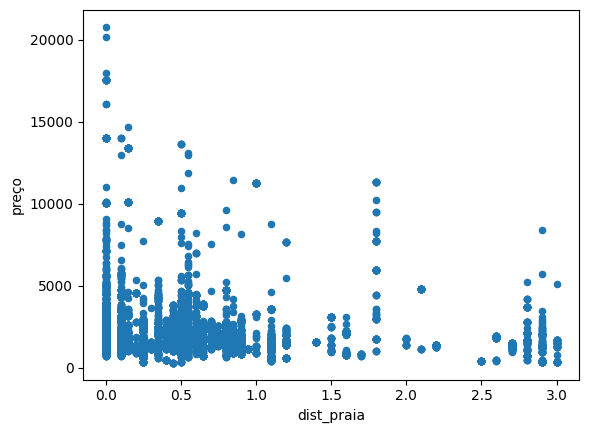

In [93]:
hosp_input.plot.scatter(x='dist_praia',y='preço')

In [94]:
hosp_input['dist_praia'].describe()

count    11037.000000
mean         0.580475
std          0.703904
min          0.000000
25%          0.100000
50%          0.450000
75%          0.750000
max          3.000000
Name: dist_praia, dtype: float64

Podemos ver que há uma relação entre preço e distância praia. Se analisarmos bem, percebemos que os dados da dist_praia variam entre 0 e 3 obrigatoriamente, fazendo com que se imagine, que dificilmente os dados que não possuem valor nesta coluna, possuam valores entre o intervalo dito. Basicamente, no Booking.com, o proprietário pode apenas optar por não colocar a distância da praia até a propriedade ou a distância colocada é maior que 3km, então, nesses casos, os valores não aparecem e assim aparecem como dados faltantes. Com isso, não faz sentido aplicar métodos de imputação sobre a coluna dist_praia, pois provavelmente os valores imputados serão entre o intervalo de 0 e 3, sendo possibilidades que podem enviesar e gerar conclusões incorretas. 


Desse modo, foi preferível apagar a coluna dist_praia

In [95]:
hosp_input = hosp_input.drop(columns=['dist_praia'])
# excluindo a coluna checkout por não ser necessária
hosp_input = hosp_input.drop(columns=['checkout'])

Algumas correlações entre varáveis parecem importantes, então vamos normalizar os dados para utilizar o KNN para imputação.

In [96]:
# normalizando os dados

columns_to_normalize = ['preço', 'dist_centro', 'avaliacao', 'qtnd_avaliacoes']
scaler = MinMaxScaler()

hosp_input[columns_to_normalize] = scaler.fit_transform(hosp_input[columns_to_normalize])

print(hosp_input)

       hotel  cidade     preço  checkin  dist_centro  avaliacao  \
0        475       0  0.074051        0     0.088565   0.755556   
1        495       0  0.067001        0     0.050448   0.822222   
2        698       0  0.009822        0     0.000000   0.811111   
3         15       0  0.038168        0     0.011211   0.966667   
4        694       0  0.074148        0     0.076233   0.811111   
...      ...     ...       ...      ...          ...        ...   
15638    458       0  0.126854       46     0.098655   0.000000   
15639    409       0  0.209899       46     0.048206   1.000000   
15640     20       0  0.185054       46     0.091928        NaN   
15641    206       0  0.266884       46     0.849776   0.966667   
15642    226       0  0.535810       46     0.173767        NaN   

       qtnd_avaliacoes  data_extracao  mes_checkin  
0             0.350000              0            7  
1             0.538036              0            7  
2             0.000226              

In [97]:
# rodando o KNN impute para imputar os dados faltantes
hosp_knn = KNN(k=3).fit_transform(hosp_input)

Imputing row 1/15643 with 0 missing, elapsed time: 165.179
Imputing row 101/15643 with 0 missing, elapsed time: 165.372
Imputing row 201/15643 with 0 missing, elapsed time: 165.521
Imputing row 301/15643 with 0 missing, elapsed time: 165.554
Imputing row 401/15643 with 0 missing, elapsed time: 165.619
Imputing row 501/15643 with 0 missing, elapsed time: 165.671
Imputing row 601/15643 with 0 missing, elapsed time: 165.675
Imputing row 701/15643 with 0 missing, elapsed time: 165.766
Imputing row 801/15643 with 0 missing, elapsed time: 165.791
Imputing row 901/15643 with 2 missing, elapsed time: 165.823
Imputing row 1001/15643 with 0 missing, elapsed time: 165.883
Imputing row 1101/15643 with 0 missing, elapsed time: 165.902
Imputing row 1201/15643 with 0 missing, elapsed time: 165.907
Imputing row 1301/15643 with 0 missing, elapsed time: 165.923
Imputing row 1401/15643 with 0 missing, elapsed time: 165.965
Imputing row 1501/15643 with 0 missing, elapsed time: 166.024
Imputing row 1601/15

In [98]:
hosp2 = pd.DataFrame(data=hosp_knn[0:,0:],columns=['hotel', 'cidade', 'preço', 'checkin', 'dist_centro', 'avaliacao', 'qtnd_avaliacoes', 'data_extracao', 'mes_checkin'])

In [99]:
# revertendo a normalização
hosp2[columns_to_normalize] = scaler.inverse_transform(hosp2[columns_to_normalize])

In [100]:
hosp2.corr(method='spearman')

,hotel,cidade,preço,checkin,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
hotel,1.000000,NaN,-0.045768,-0.013961,-0.052071,-0.157560,0.147891,NaN,0.012697
cidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preço,-0.045768,NaN,1.000000,0.092607,0.114370,0.110885,0.029555,NaN,-0.049790
checkin,-0.013961,NaN,0.092607,1.000000,-0.014037,0.027313,-0.090313,NaN,-0.298065
dist_centro,-0.052071,NaN,0.114370,-0.014037,1.000000,-0.027818,0.110918,NaN,0.009141
avaliacao,-0.157560,NaN,0.110885,0.027313,-0.027818,1.000000,-0.231401,NaN,-0.008061
qtnd_avaliacoes,0.147891,NaN,0.029555,-0.090313,0.110918,-0.231401,1.000000,NaN,0.051540
data_extracao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mes_checkin,0.012697,NaN,-0.049790,-0.298065,0.009141,-0.008061,0.051540,NaN,1.000000


In [101]:
# mediana antiga
hosp_input[columns_to_normalize] = scaler.inverse_transform(hosp_input[columns_to_normalize])
hosp_input.median()

hotel               389.0
cidade                0.0
preço              1638.0
checkin              16.0
dist_centro           6.8
avaliacao             8.6
qtnd_avaliacoes      14.0
data_extracao         0.0
mes_checkin           8.0
dtype: float64

In [102]:
#nova mediana
hosp2.median()

hotel               389.0
cidade                0.0
preço              1638.0
checkin              16.0
dist_centro           6.8
avaliacao             8.7
qtnd_avaliacoes      13.0
data_extracao         0.0
mes_checkin           8.0
dtype: float64

In [103]:
# passando os dados imputados para o dataset padrao
hospedagens['avaliacao'] = hosp2['avaliacao']
hospedagens['qtnd_avaliacoes'] = hosp2['qtnd_avaliacoes']

C:\Users\Clara\AppData\Local\Temp\ipykernel_37468\135721882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['avaliacao'] = hosp2['avaliacao']
C:\Users\Clara\AppData\Local\Temp\ipykernel_37468\135721882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['qtnd_avaliacoes'] = hosp2['qtnd_avaliacoes']


In [104]:
hospedagens = hospedagens.drop(columns=['dist_praia'])
print(hospedagens.isnull().sum())


hotel              0
cidade             0
preço              0
checkin            0
checkout           0
dist_centro        0
avaliacao          0
qtnd_avaliacoes    0
data_extracao      0
mes_checkin        0
dtype: int64


## Outliers


Como nosso objetivo é analisar principalmente o preço das hospedagens, vamos focar na remoção de outliers sobre a coluna preço

In [105]:
duplicated_entries = hospedagens[hospedagens.duplicated(subset=['checkin', 'hotel', 'preço'], keep=False)]

# Agrupar e contar ocorrências de duplicatas
duplicated_counts = duplicated_entries.groupby(['checkin', 'hotel', 'preço']).size().reset_index(name='count')

# Filtrar apenas os registros com mais de uma ocorrência
duplicated_counts = duplicated_counts[duplicated_counts['count'] > 1]

# Printar os resultados
print("Hotéis duplicados por mês de check-in:")
print(duplicated_counts)

# Quantidade total de duplicatas
total_duplicates = duplicated_counts['count'].sum()
print("Total de registros duplicados:", total_duplicates)

# Remover as duplicatas do DataFrame original
hospedagens = hospedagens.drop_duplicates(subset=['checkin', 'hotel', 'preço'], keep='first')

C:\Users\Clara\AppData\Local\Temp\ipykernel_37468\3177665228.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duplicated_counts = duplicated_entries.groupby(['checkin', 'hotel', 'preço']).size().reset_index(name='count')


Hotéis duplicados por mês de check-in:
          checkin                            hotel  preço  count
732    2024-07-01                           Duplex    714      2
2895   2024-07-08                           Duplex    714      2
4445   2024-07-15  Apartamento Beira Mar em Recife   9450      2
6608   2024-07-22  Apartamento Beira Mar em Recife   9450      2
8771   2024-08-01  Apartamento Beira Mar em Recife   9450      2
...           ...                              ...    ...    ...
95904  2025-06-08                           Duplex    714      2
98067  2025-06-15                           Duplex    714      2
98473  2025-06-15               Flat em Boa Viagem   4760      2
100230 2025-06-22                           Duplex    714      2
100636 2025-06-22               Flat em Boa Viagem   4760      2

[101 rows x 4 columns]
Total de registros duplicados: 202


In [106]:
hospedagens.shape

(15542, 10)

In [107]:
# Realizar o teste de Shapiro-Wilk na coluna 'preço'
shapiro_result = stats.shapiro(hospedagens['preço'])
statistic, p_value = shapiro_result

print(f"Shapiro-Wilk statistic: {statistic}, p-value: {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: Os dados não seguem uma distribuição normal.")
else:
    print("Falhamos em rejeitar a hipótese nula: Os dados seguem uma distribuição normal.")

Shapiro-Wilk statistic: 0.6198935705677149, p-value: 2.4858764118323003e-102
Rejeitamos a hipótese nula: Os dados não seguem uma distribuição normal.


c:\Users\Clara\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15542.
  res = hypotest_fun_out(*samples, **kwds)


<Axes: >

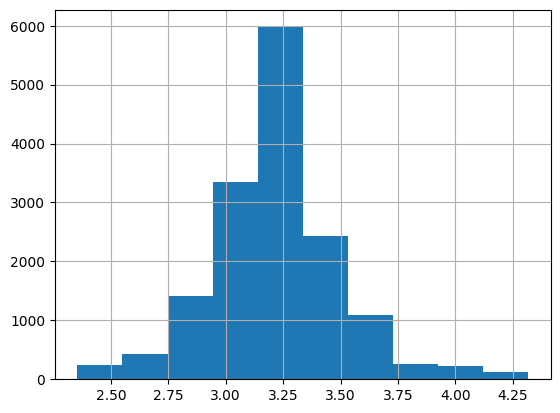

In [108]:
# plotando um histograma com valores normalizados do preço
# como vimos em cima, os dados são assimétricos e é necessário a aplicação do log10 sobre o preço
hospedagens['log_price'] = hospedagens['preço'].apply(np.log10)
hospedagens[hospedagens['log_price'] > 0]['log_price'].hist()

In [109]:
# Realizar o teste de Shapiro-Wilk na coluna 'log_price'
shapiro_result = stats.shapiro(hospedagens['log_price'])
statistic, p_value = shapiro_result

print(f"Shapiro-Wilk statistic: {statistic}, p-value: {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: Os dados não seguem uma distribuição normal.")
else:
    print("Falhamos em rejeitar a hipótese nula: Os dados seguem uma distribuição normal.")

Shapiro-Wilk statistic: 0.9738080421775989, p-value: 4.335620149227046e-46
Rejeitamos a hipótese nula: Os dados não seguem uma distribuição normal.


c:\Users\Clara\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15542.
  res = hypotest_fun_out(*samples, **kwds)


In [130]:
# normalizando os dados
scaler = MinMaxScaler()

hospedagens['preço_normalizado'] = scaler.fit_transform(hospedagens[['log_price']])
print(hospedagens)

                                                   hotel  cidade  preço  \
0                     Hotel Euro Suíte Recife Boa Viagem  Recife   1749   
1                      Kastel Manibu Recife - Boa Viagem  Recife   1604   
2      Veja o mar no silêncio do centro! Hospede-se n...  Recife    428   
3      Aconchegante Apto de 1qt a 60mts do Consulado EUA  Recife   1011   
4                                Transamerica Fit Recife  Recife   1751   
...                                                  ...     ...    ...   
15638                                  Hostel da Socorro  Recife   2835   
15639                 Flat no melhor lugar de boa viagem  Recife   4543   
15640                               Aconchego Boa Viagem  Recife   4032   
15641    Casa Pontal dos Carneiros - Praia dos Carneiros  Recife   5715   
15642                   Cond Clube em Piedade noCarnaval  Recife  11246   

         checkin   checkout  dist_centro  avaliacao  qtnd_avaliacoes  \
0     2024-07-01 2024-07-08

In [131]:
# Realizar o teste de Shapiro-Wilk na coluna 'preço'
shapiro_result = stats.shapiro(hospedagens['preço_normalizado'])
statistic, p_value = shapiro_result

print(f"Shapiro-Wilk statistic: {statistic}, p-value: {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: Os dados não seguem uma distribuição normal.")
else:
    print("Falhamos em rejeitar a hipótese nula: Os dados seguem uma distribuição normal.")

Shapiro-Wilk statistic: 0.9738080421776001, p-value: 4.335620149234414e-46
Rejeitamos a hipótese nula: Os dados não seguem uma distribuição normal.


c:\Users\Clara\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15542.
  res = hypotest_fun_out(*samples, **kwds)


<Axes: >

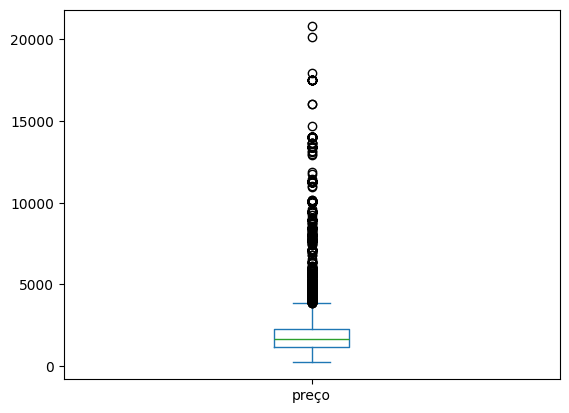

In [112]:
hospedagens[['preço']].plot(kind='box')


In [113]:
hospedagens.dtypes

hotel                      category
cidade                     category
preço                         int64
checkin              datetime64[ns]
checkout             datetime64[ns]
dist_centro                 float64
avaliacao                   float64
qtnd_avaliacoes             float64
data_extracao              category
mes_checkin                   int32
log_price                   float64
preço_normalizado           float64
dtype: object

Como podemos ver no boxplot, existem uma considerável quantidade de outliers em vários meses do nosso dataset. Como queremos entender as variabilidades do preço durante os meses, se tornou interessante a alternativa de remover os outliers por meses ao invés de remover pelo dataset inteiro.

In [114]:
# calculando o iqr por mês dos preços em log10
grouped = hospedagens.groupby('mes_checkin')['log_price']

q1_per_month = grouped.quantile(0.25)
q3_per_month = grouped.quantile(0.75)

iqr_per_month = q3_per_month - q1_per_month

print('iqr: ', iqr_per_month)

iqr:  mes_checkin
1     0.307016
2     0.341651
3     0.406200
4     0.371278
5     0.366135
6     0.385967
7     0.237284
8     0.234822
9     0.243876
10    0.246672
11    0.249558
12    0.281956
Name: log_price, dtype: float64


In [115]:
# Aplicar a condição de Tukey ajustada diretamente ao DataFrame original
# Remove os outliers por mês de acordo com seu IQR
hospedagens_clean = hospedagens.groupby('mes_checkin').apply(lambda x: x[
    (x['log_price'] >= (q1_per_month[x.name] - 1.5 * iqr_per_month[x.name])) &
    (x['log_price'] <= (q3_per_month[x.name] + 1.5 * iqr_per_month[x.name]))
]).reset_index(drop=True)

In [116]:
# dataset após a remoção
hospedagens_clean

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,preço_normalizado
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.600000,1620.000000,2024-6-6,1,3.142702,0.056547
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,7.300000,393.000000,2024-6-6,1,2.905796,0.028152
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,9.100000,14.000000,2024-6-6,1,2.984077,0.035883
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,10.000000,1.000000,2024-6-6,1,3.007321,0.038460
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,9.500000,105.000000,2024-6-6,1,3.037825,0.042058
...,...,...,...,...,...,...,...,...,...,...,...,...
14594,Apto a beira-mar em Jaboatao dos Guararapes PE,Recife,4128,2024-12-22,2024-12-29,19.4,9.000000,2.000000,2024-6-6,12,3.615740,0.189721
14595,Hostel da Socorro,Recife,2835,2024-12-22,2024-12-29,9.0,1.000000,1.000000,2024-6-6,12,3.452553,0.126854
14596,Flat Equipado-Jaqueira Otima Localização-SH032,Recife,4544,2024-12-22,2024-12-29,3.0,8.200000,6.000000,2024-6-6,12,3.657438,0.209948
14597,Lindo apto à beira-mar Jaboatão dos Guararapes...,Recife,5514,2024-12-22,2024-12-29,16.6,7.000000,1.000000,2024-6-6,12,3.741467,0.257111


In [117]:
# média nova dos preços de cada mês
preco_medio_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()
preco_medio_mensal

checkin
2024-07-31    1716.785895
2024-08-31    1647.363684
2024-09-30    1715.138668
2024-10-31    1756.863609
2024-11-30    1801.569192
2024-12-31    2015.416533
2025-01-31    2122.436567
2025-02-28    1980.164948
2025-03-31    2604.799180
2025-04-30    2095.903846
2025-05-31    2010.349415
2025-06-30    1867.577086
Freq: M, Name: preço, dtype: float64

In [118]:
# mediana nova dos preços de cada mês
preco_mediano_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()
preco_mediano_mensal

checkin
2024-07-31    1575.0
2024-08-31    1487.0
2024-09-30    1593.0
2024-10-31    1618.0
2024-11-30    1638.0
2024-12-31    1712.0
2025-01-31    1960.0
2025-02-28    1700.0
2025-03-31    1895.0
2025-04-30    1747.0
2025-05-31    1687.0
2025-06-30    1575.0
Freq: M, Name: preço, dtype: float64

É possível notar algumas mudanças nesses dados em comparação com o dataset antes da remoção, mas a variação nos dados por mês permanece, inclusive ainda há uma "alta" variação nos meses de janeiro e março, meses que possuem épocas festivas. 

<Axes: >

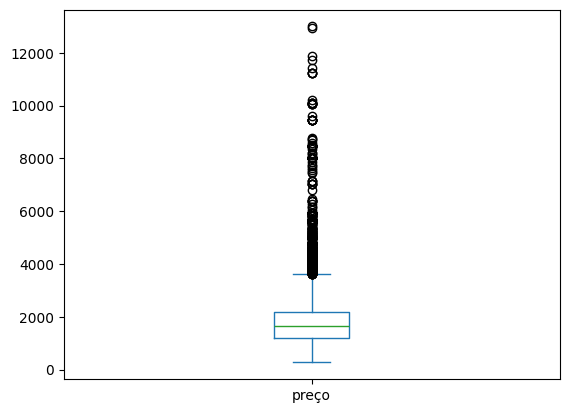

In [119]:
hospedagens_clean['preço'].plot(kind='box')

In [120]:
hospedagens_clean.describe()

,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,mes_checkin,log_price,preço_normalizado
count,14599.000000,14599,14599,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000
mean,1873.288376,2024-11-16 02:45:30.762380800,2024-11-23 02:45:30.762381056,8.236718,8.268823,421.855752,7.390027,3.215519,0.080094
min,268.000000,2024-07-01 00:00:00,2024-07-08 00:00:00,0.200000,1.000000,1.000000,1.000000,2.428135,0.002042
25%,1190.000000,2024-08-22 00:00:00,2024-08-29 00:00:00,4.400000,7.700000,3.000000,5.000000,3.075547,0.046871
50%,1638.000000,2024-11-01 00:00:00,2024-11-08 00:00:00,6.800000,8.700000,13.000000,8.000000,3.214314,0.068654
75%,2165.000000,2025-01-22 00:00:00,2025-01-29 00:00:00,9.500000,9.500000,82.000000,10.000000,3.335458,0.094277
max,13000.000000,2025-06-22 00:00:00,2025-06-29 00:00:00,89.400000,10.000001,8861.000000,12.000000,4.113943,0.621092
std,1082.378529,NaN,NaN,7.009025,1.885859,1119.919483,3.257766,0.218999,0.052627


Apesar de o gráfico ainda, aparentemente, apresentar outliers, muitos foram removidos e houve um ajuste significativo.

## Discretização

Decidimos discretizar as colunas principais da nossa análise: Preço e Mes_checkin.
Discretizamos preço para gerar categorias de preço, variando de econômico até muito caro. Esse é um bom jeito para visualizar oportunidades, podendo filtrar os dados pela tag "econômico" para visualizar boas oportunidades de preço.
E, também, aplicamos categorias de estações do ano através da discretização, para assim ficar mais fácil a visualização futura de insights sobre estações do ano e sua variabilidade no preço.

In [121]:
# Discretizar a coluna de preços em 5 categorias
hospedagens_clean['price_category'] = pd.qcut(hospedagens_clean['preço'], 5, labels=['Econômico', 'Baixo', 'Médio', 'Caro', 'Muito Caro'])


In [122]:
hospedagens_clean.head()

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,preço_normalizado,price_category
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.6,1620.0,2024-6-6,1,3.142702,0.056547,Baixo
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,7.3,393.0,2024-6-6,1,2.905796,0.028152,Econômico
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,9.1,14.0,2024-6-6,1,2.984077,0.035883,Econômico
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,10.0,1.0,2024-6-6,1,3.007321,0.038460,Econômico
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,9.5,105.0,2024-6-6,1,3.037825,0.042058,Econômico


In [123]:
# Definir a função para mapear os meses para as estações do ano
def month_to_season(month):
    if month in [9, 10, 11]:
        return 'Primavera'
    elif month in [12, 1, 2]:
        return 'Verão'
    elif month in [3, 4, 5]:
        return 'Outono'
    else:
        return 'Inverno'

# Discretizar os meses e adicionar categorias de estações do ano
hospedagens_clean['season'] = hospedagens_clean['mes_checkin'].apply(month_to_season)
hospedagens_clean.head(10)

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,preço_normalizado,price_category,season
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.6,1620.0,2024-6-6,1,3.142702,0.056547,Baixo,Verão
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,7.3,393.0,2024-6-6,1,2.905796,0.028152,Econômico,Verão
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,9.1,14.0,2024-6-6,1,2.984077,0.035883,Econômico,Verão
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,10.0,1.0,2024-6-6,1,3.007321,0.038460,Econômico,Verão
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,9.5,105.0,2024-6-6,1,3.037825,0.042058,Econômico,Verão
5,Bonito é ser Feliz,Recife,684,2025-01-01,2025-01-08,4.8,9.8,46.0,2024-6-6,1,2.835056,0.022269,Econômico,Verão
6,Park Hotel,Recife,2684,2025-01-01,2025-01-08,8.6,8.5,5064.0,2024-6-6,1,3.428783,0.119512,Muito Caro,Verão
7,Rede Andrade LG Inn,Recife,1827,2025-01-01,2025-01-08,6.8,7.7,8861.0,2024-6-6,1,3.261739,0.077843,Caro,Verão
8,Qto Duplo próximo ao Shopping Recife,Recife,625,2025-01-01,2025-01-08,8.1,10.0,3.0,2024-6-6,1,2.795880,0.019400,Econômico,Verão
9,Hotel Pousada Casa Grande,Recife,1190,2025-01-01,2025-01-08,11.5,8.0,2.0,2024-6-6,1,3.075547,0.046871,Baixo,Verão


In [124]:
hospedagens_clean[hospedagens_clean['mes_checkin'] == 12].head()

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,preço_normalizado,price_category,season
13353,Hotel Golden Park Recife Boa Viagem,Recife,1722,2024-12-01,2024-12-08,9.3,7.5,2655.0,2024-6-6,12,3.236033,0.072738,Médio,Verão
13354,Transamerica Fit Recife,Recife,1648,2024-12-01,2024-12-08,7.0,8.3,5177.0,2024-6-6,12,3.216957,0.069140,Médio,Verão
13355,Aconchegante Apto de 1qt a 60mts do Consulado EUA,Recife,1011,2024-12-01,2024-12-08,1.2,9.7,36.0,2024-6-6,12,3.004751,0.038168,Econômico,Verão
13356,Park Hotel,Recife,2095,2024-12-01,2024-12-08,8.6,8.5,5064.0,2024-6-6,12,3.321184,0.090874,Caro,Verão
13357,Hotel Central,Recife,805,2024-12-01,2024-12-08,0.8,7.3,393.0,2024-6-6,12,2.905796,0.028152,Econômico,Verão


In [125]:
hospedagens_clean[hospedagens_clean['price_category'] == 'Baixo']

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,preço_normalizado,price_category,season
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.600000,1620.000000,2024-6-6,1,3.142702,0.056547,Baixo,Verão
9,Hotel Pousada Casa Grande,Recife,1190,2025-01-01,2025-01-08,11.5,8.000000,2.000000,2024-6-6,1,3.075547,0.046871,Baixo,Verão
25,ibis budget Recife Jaboatão,Recife,1265,2025-01-01,2025-01-08,12.7,8.400000,2077.000000,2024-6-6,1,3.102091,0.050518,Baixo,Verão
34,Pousada Nordestina,Recife,1260,2025-01-01,2025-01-08,14.1,7.300000,253.000000,2024-6-6,1,3.100371,0.050275,Baixo,Verão
46,Espaço inteiro a beira mar,Recife,1428,2025-01-01,2025-01-08,7.0,10.000000,2.000000,2024-6-6,1,3.154728,0.058443,Baixo,Verão
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14529,Pousada Shalom,Recife,1190,2024-12-22,2024-12-29,4.8,7.201257,341.754484,2024-6-6,12,3.075547,0.046871,Baixo,Verão
14530,Aurora Recife Hostel,Recife,1176,2024-12-22,2024-12-29,1.1,8.965950,574.734345,2024-6-6,12,3.070407,0.046190,Baixo,Verão
14545,Quarto Litoral Sul,Recife,1418,2024-12-22,2024-12-29,4.5,1.000000,1.000000,2024-6-6,12,3.151676,0.057957,Baixo,Verão
14571,Bugan Paiva flatpaivahome,Recife,1386,2024-12-22,2024-12-29,19.6,8.000000,5.000000,2024-6-6,12,3.141763,0.056401,Baixo,Verão


## Teste de hipótese

Existe uma variação significativa nos preços que possa indicar uma alta e baixa temporada no local?


Para isso, utilizamos o teste de hipótese 'Kruskal-Wallis' pois:

- Assume variáveis não paramétricas: Nossa distribuição não é simétrica.
- Compara 3 ou mais grupos: Por estar separado por meses, precisávamos de um teste que pudesse ser aplicado para todos os 12 grupos
- Compara grupos distintos: Os dados de cada mês são diferentes uns dos outros

Hipótese Nula (H0): Os preços dos hotéis não variam significativamente entre os meses.

Hipótese Alternativa (HA): Os preços dos hotéis variam significativamente entre os meses

In [126]:

# Filtrar dados por mês
grouped = hospedagens_clean.groupby('mes_checkin')['preço'].apply(list)

# Realizar Kruskal-Wallis
h_statistic, p_value = kruskal(*grouped)

print(f"Kruskal-Wallis H-Statistic: {h_statistic}, p-value: {p_value}")

# Verificar resultado
if p_value < 0.01:
    print("Rejeitamos a hipótese nula: Existe uma variação significativa nos preços entre os meses.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não existe uma variação significativa nos preços entre os meses.")


Kruskal-Wallis H-Statistic: 285.90615959231144, p-value: 8.120275671582972e-55
Rejeitamos a hipótese nula: Existe uma variação significativa nos preços entre os meses.


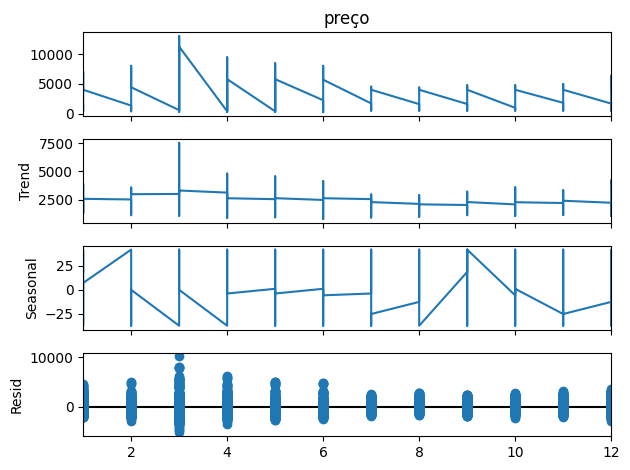

In [127]:

# Supondo que você tenha uma série temporal de preços
hospedagens_clean = hospedagens_clean.set_index('mes_checkin')

# Realizar a decomposição
result = seasonal_decompose(hospedagens_clean['preço'], model='additive', period=12)  # Ajustar 'period' conforme necessário

# Plotar os componentes
result.plot()
plt.show()


Com isso, percebemos, que sim, os dados possuem uma certa variação de preço entre os meses.